# 3. Correct for Milky Way Extinction

When we observe an extragalactic transient, absorption of light by the intervening interstellar dust grains in the Milky Way alters the observed spectrum. We can describe this effect as either *extinction*, which makes the source appear dimmer in any given band, or as *reddening*, a change in the color between two bands. We have to correct for this effect or *deredden* before we can analyze the data.

The *total extinction* $A(\lambda)$ at a wavelength $\lambda$ is defined as the difference between the observed magnitude and the emitted or intrinsic magnitude in that band:

$$ A(\lambda) = m_\mathrm{observed}(\lambda) - m_\mathrm{intrinsic}(\lambda) $$

The *selective extinction* is defined as the color change between two bands:

$$ E(\lambda_1 - \lambda_2) = A(\lambda_1) - A(\lambda_2) $$

It is found emperically that extinction along most lines of site is well fit by a family of curves parameterized by $R_V = A(V) / E(B - V)$. This curve is called an *extinction law*. A classic and commonly used extinction law is [Fitzpatrick (1999)](http://adsabs.harvard.edu/abs/1999PASP..111...63F), reproduced below.

![Reddening image](http://cdn.iopscience.com/images/1538-3873/111/755/63/Full/fg1.jpg)

In principle, both $R_V$ and $E(B - V)$ vary across the sky. In practice, we usually assume a fixed value of $R_V = 3.1$ which is the mean value for the Milky Way, and look up $E(B - V)$ from an online interstellar dust map.

We will be using the handy [IRSA Dust Service](http://irsa.ipac.caltech.edu/applications/DUST/). We will be querying it using the even handier [Astroquery](https://astroquery.readthedocs.io/) Python package, which provides a Python interface for a large number of online astronomical data services. We will use the [Specutils](http://specutils.readthedocs.io/) Python package to evaluate the Fitzpatrick extinction law. (You may need to install both of these packages by running `pip install astroquery specutils`.)

(In principle, if we have enough data and a sufficiently accurate model of the source spectrum, we could also fit for the reddening due to the transient's host galaxy.)

## Imports

In [1]:
# Third party Python packages
from astropy import table
from astropy import constants as c
from astropy import units as u
from astroquery.irsa_dust import IrsaDust
from matplotlib import pyplot as plt
import numpy as np
from specutils.extinction import extinction_f99

# IPython configuration:
# Plots will appear inside the notebook
# instead of in a new window.
%matplotlib inline

## Load our other data sets

In [2]:
filters = table.Table.read('data/filters.ecsv', format='ascii.ecsv')
photometry = table.Table.read('data/photometry.ecsv', format='ascii.ecsv')

## Look up extinction by band

Query the IRSA Dust service. We can actually ask for an extinction table by *band*...

In [3]:
extinction_table = IrsaDust.get_extinction_table('NGC 4993')
extinction_table

Filter_name,LamEff,A_over_E_B_V_SandF,A_SandF,A_over_E_B_V_SFD,A_SFD
,microns,,mags,,mags
str8,float64,float64,float64,float64,float64
CTIO U,0.3734,4.107,0.508,4.968,0.615
CTIO B,0.4309,3.641,0.451,4.325,0.535
CTIO V,0.5517,2.682,0.332,3.24,0.401
CTIO R,0.652,2.119,0.262,2.634,0.326
CTIO I,0.8007,1.516,0.188,1.962,0.243
DSS-II g,0.4621,3.381,0.418,3.907,0.484
DSS-II r,0.6546,2.088,0.258,2.649,0.328
DSS-II i,0.8111,1.487,0.184,1.893,0.234


Unfortunately, if we plot the extinction by wavelength, we will see that the table does not go to sufficiently short (blue) wavelengths for our data set, so we have to actually use the Fitzpatrick reddening law.

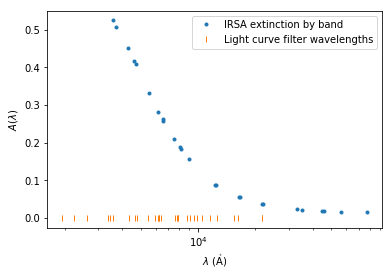

In [4]:
ax = plt.axes()
ax.set_xscale('log')
ax.set_xlabel('$\lambda$ ($\mathrm{\mathring{A}}$)')
ax.set_ylabel('$A(\lambda)$')
ax.plot(
    (np.asarray(extinction_table['LamEff']) * u.micron).to(u.angstrom),
    extinction_table['A_SandF'],
    '.', label='IRSA extinction by band')
ax.plot(
    filters['wavelength'],
    np.zeros_like(filters['wavelength']),
    '|', label='Light curve filter wavelengths')
ax.legend()

## Look up reddening and use extinction law

We will instead use the IRSA Dust service to look up the value of $E(B-V)$ in the direction of NGC 4993, and then evaluate the Fitzpatrick extinction law for each band using this value.

In [5]:
# Query IRSA dust service
reddening_table = IrsaDust.get_query_table('NGC 4993')
reddening_table

RA,Dec,coord sys,regSize,ext desc,ext image,ext table,ext SandF ref,ext SandF ref RA,ext SandF ref Dec,ext SandF ref coord sys,ext SandF mean,ext SandF std,ext SandF max,ext SandF min,ext SFD ref,ext SFD ref RA,ext SFD ref Dec,ext SFD ref coord sys,ext SFD mean,ext SFD std,ext SFD max,ext SFD min,em desc,em image,em ref,em ref RA,em ref Dec,em ref coord sys,em mean,em std,em max,em min,temp desc,temp image,temp ref,temp ref RA,temp ref Dec,temp ref coord sys,temp mean,temp std,temp max,temp min
deg,deg,,deg,,,,,deg,deg,,,,,,,deg,deg,,,,,,,,,deg,deg,,,,,,,,,deg,deg,,,,,
float64,float64,bytes25,float64,bytes100,bytes255,bytes255,float64,float64,float64,bytes25,float64,float64,float64,float64,float64,float64,float64,bytes25,float64,float64,float64,float64,bytes100,bytes255,float64,float64,float64,bytes25,float64,float64,float64,float64,bytes100,bytes255,float64,float64,float64,bytes25,float64,float64,float64,float64
197.44875,-23.38389,equ J2000,5.0,E(B-V) Reddening,https://irsa.ipac.caltech.edu:443//workspace/TMP_GhvoXA_19318/DUST/NGC_4993.v0001/p146Dust.fits,https://irsa.ipac.caltech.edu:443//workspace/TMP_GhvoXA_19318/DUST/NGC_4993.v0001/extinction.tbl,0.1064,197.44875,-23.38389,equ J2000,0.1053,0.0012,0.1077,0.1032,0.1238,197.44875,-23.38389,equ J2000,0.1225,0.0014,0.1253,0.12,100 Micron Emission,https://irsa.ipac.caltech.edu:443//workspace/TMP_GhvoXA_19318/DUST/NGC_4993.v0001/p146i100.fits,6.3318,197.44875,-23.38389,equ J2000,6.2683,0.0919,6.4431,6.0881,Dust Temperature,https://irsa.ipac.caltech.edu:443//workspace/TMP_GhvoXA_19318/DUST/NGC_4993.v0001/p146temp.fits,18.0309,197.44875,-23.38389,equ J2000,18.038,0.0094,18.0668,18.0177


Calculate extinction by band using the Fitzpatrick 1999 law.

In [6]:
rv = 3.1
ebv = reddening_table['ext SandF mean']
av = rv * ebv
ext_f99 = extinction_f99(filters['wavelength'].quantity, a_v=av, r_v=rv)

Let's plot the extinction calculated with Specutils to make sure that it matches the IRSA extinction by band.

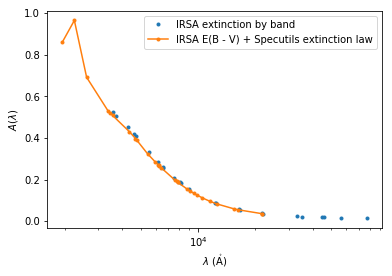

In [7]:
ax = plt.axes()
ax.set_xscale('log')
ax.set_xlabel('$\lambda$ ($\mathrm{\mathring{A}}$)')
ax.set_ylabel('$A(\lambda)$')
ax.plot(
    (np.asarray(extinction_table['LamEff']) * u.micron).to(u.angstrom),
    extinction_table['A_SandF'],
    '.', label='IRSA extinction by band')
ax.plot(
    filters['wavelength'],
    ext_f99, marker='.',
    label='IRSA E(B - V) + Specutils extinction law')
ax.legend()

Looks spiffy. Let's turn that into an Astropy table!

In [8]:
extinction = table.Table(
    [filters['band'], ext_f99],
    names=['band', 'extinction'])
extinction['extinction'].unit = u.mag
extinction

band,extinction
,mag
str5,float64
W2,0.860877846971
M2,0.965626487464
W1,0.69219771359
F336W,0.531568336855
U,0.520098465337
u,0.508545977833
B,0.430081621344
g,0.397580726843


## Convert from magnitudes to flux density

Last, we are going to de-redden the observations.

We will need to combine all three of our tables (`photometry`, `filters`, and `extinction`). Astropy has a handy [`join` method](http://docs.astropy.org/en/stable/table/operations.html#join) that combines two tables by matching together rows with equal values of specified columns (by default, columns that appear in both tables). This is similar to a [`join` operation in SQL](https://en.wikipedia.org/wiki/Join_(SQL).

In [9]:
data = table.join(photometry, filters)
data = table.join(data, extinction)
data

telescope,instrument,band,time,magnitude,e_magnitude,wavelength,extinction
,,,d,mag,mag,Angstrom,mag
str10,str11,str5,float64,float64,float64,float64,float64
SSO,--,B,1.82999535417,20.1,0.12,4371.22288257,0.430081621344
Magellan,LDSS,B,4.49317635416,22.52,0.14,4371.22288257,0.430081621344
Magellan,LDSS,B,7.50167635417,23.85,0.31,4371.22288257,0.430081621344
VLT,FORS2,B,6.49147635416,23.807,0.251,4371.22288257,0.430081621344
CTIO,--,B,1.45999535416,19.09,0.11,4371.22288257,0.430081621344
SAAO,--,B,1.18999535417,18.47,0.11,4371.22288257,0.430081621344
VLT,FORS2,B,4.49147635416,22.729,0.128,4371.22288257,0.430081621344
SAAO,--,B,2.18999535417,20.45,0.09,4371.22288257,0.430081621344


Now correct the magnitudes for extinction.

In [10]:
dereddened_magnitude = data.columns.pop('magnitude') - data.columns.pop('extinction')

At this time, we will also convert the dataset from magnitudes, which are convenient for observations, to flux densities, which are physical units that are more natural for analysis.

In [11]:
data['fluxdensity'] = (dereddened_magnitude * u.ABmag).to(u.mJy)

We need to convert the error bars from magnitudes to flux density using propagation of errors. Recall that if you have a quantities $x$ and $y$ with uncertainties $\sigma_x$ and $\sigma_y$, then the uncertainty in $z = f(x, y)$ is

$$
    \sigma_z = \sqrt{\left(\frac{\partial f(x,y)}{\partial x} \sigma_x\right)^2 + \left(\frac{\partial f(x,y)}{\partial y} \sigma_y\right)^2}.
$$

Since we know that

$$
    m(AB) = -2.5 \log_{10} \left( \frac{F_\nu}{3631\,\mathrm{Jy}} \right)
$$

and

$$
    F_\nu = 10^{-0.4 \, m(AB)} \cdot (3631 \, \mathrm{Jy}),
$$

we find that

$$
    \sigma_{F_\nu} = \frac{\ln 10}{2.5} \sigma_{m(AB)} F_\nu.
$$

In [12]:
data['e_fluxdensity'] = np.log(10) / 2.5 * data['fluxdensity'].quantity * data.columns.pop('e_magnitude') / u.mag

Lastly, let's convert from wavelength to frequency (the more natural choice since we are using the flux density per unit *frequency* $F_\nu$ rather than the flux density per unit *wavelength* $F_\lambda$). We can do this using $c = \nu \lambda$:

In [13]:
(c.c / data['wavelength'].quantity).to(u.Hz)

<Quantity [  6.85832011e+14,  6.85832011e+14,  6.85832011e+14,
             6.85832011e+14,  6.85832011e+14,  6.85832011e+14,
             6.85832011e+14,  6.85832011e+14,  6.85832011e+14,
             6.85832011e+14,  6.85832011e+14,  6.85832011e+14,
             6.85832011e+14,  6.85832011e+14,  6.85832011e+14,
             2.60348033e+14,  2.60348033e+14,  2.60348033e+14,
             2.60348033e+14,  2.60348033e+14,  2.60348033e+14,
             2.60348033e+14,  1.94253218e+14,  1.94253218e+14,
             1.94253218e+14,  1.94253218e+14,  1.94253218e+14,
             1.94253218e+14,  1.94253218e+14,  8.90030101e+14,
             8.90030101e+14,  8.90030101e+14,  8.90030101e+14,
             6.28736000e+14,  6.28736000e+14,  6.28736000e+14,
             6.28736000e+14,  6.28736000e+14,  6.28736000e+14,
             6.28736000e+14,  5.04578916e+14,  5.04578916e+14,
             5.04578916e+14,  5.04578916e+14,  4.77840083e+14,
             3.88076248e+14,  3.83650295e+14,  3.836502

But Astropy has an even cooler way to do this using unit *equivalencies*:

In [14]:
data['wavelength'].quantity.to(u.Hz, equivalencies=u.spectral())

<Quantity [  6.85832011e+14,  6.85832011e+14,  6.85832011e+14,
             6.85832011e+14,  6.85832011e+14,  6.85832011e+14,
             6.85832011e+14,  6.85832011e+14,  6.85832011e+14,
             6.85832011e+14,  6.85832011e+14,  6.85832011e+14,
             6.85832011e+14,  6.85832011e+14,  6.85832011e+14,
             2.60348033e+14,  2.60348033e+14,  2.60348033e+14,
             2.60348033e+14,  2.60348033e+14,  2.60348033e+14,
             2.60348033e+14,  1.94253218e+14,  1.94253218e+14,
             1.94253218e+14,  1.94253218e+14,  1.94253218e+14,
             1.94253218e+14,  1.94253218e+14,  8.90030101e+14,
             8.90030101e+14,  8.90030101e+14,  8.90030101e+14,
             6.28736000e+14,  6.28736000e+14,  6.28736000e+14,
             6.28736000e+14,  6.28736000e+14,  6.28736000e+14,
             6.28736000e+14,  5.04578916e+14,  5.04578916e+14,
             5.04578916e+14,  5.04578916e+14,  4.77840083e+14,
             3.88076248e+14,  3.83650295e+14,  3.836502

In [15]:
data['frequency'] = data.columns.pop('wavelength').quantity.to(u.Hz, equivalencies=u.spectral())

Finally, let's sort the table by time and frequency.

In [16]:
data.sort(['time', 'frequency'])

Let's take a look at the resulting table.

In [17]:
data

telescope,instrument,band,time,fluxdensity,e_fluxdensity,frequency
,,,d,mJy,mJy,Hz
str10,str11,str5,float64,float64,float64,float64
Swope,Swope,i,0.452876354163,0.444468580565,0.0081874138233,3.97938911633e+14
Magellan,FourStar,H,0.461676354166,0.189628995087,0.0261982138373,1.83819021543e+14
Prompt5,--,r,0.464476354168,0.48381733433,0.0133683669811,4.85534389418e+14
VISTA,VIRCAM,Ks,0.470476354169,0.133852116895,0.00616411778058,1.39069259261e+14
Magellan,FourStar,J,0.471476354166,0.289308462504,0.0399694411823,2.39114850432e+14
Magellan,LDSS,z,0.471476354166,0.357825144994,0.00988707413713,3.41383633783e+14
Magellan,LDSS,r,0.471476354166,0.54535766851,0.0100458595029,4.85534389418e+14
Magellan,LDSS,V,0.471476354166,0.561860955361,0.0103498612812,5.5096764044e+14


## Save as ASCII

In [18]:
data.write('data/obs.ecsv', format='ascii.ecsv', overwrite=True)